# ATTRIBUTE / FEATURE SELECTION

First, relevant libraries are imported

In [1]:
from sklearn.datasets import load_boston
from sklearn import tree
from sklearn.cross_validation import train_test_split, cross_val_score, KFold
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from sklearn.grid_search import GridSearchCV
# Attribute selection methods from sklearn
from sklearn.feature_selection import SelectKBest, SelectPercentile, chi2, f_classif, f_regression

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## RANKING/FILTER ATTRIBUTE SELECTION WITH TRAIN / TEST

In [2]:
boston = load_boston()
X, y = boston.data, boston.target
print(X.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=33)

(506, 13)


Let's see the estimated accuracy with the original dataset (all the attributes)

In [6]:
print X_train.shape[1]


13


In [13]:
clf = tree.DecisionTreeRegressor()
clf = clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print metrics.mean_squared_error(y_test, y_test_pred)

16.8620689655


(12, -366.83409486706984)
(5, -308.37535794972143)
(10, -103.27726686601569)
(2, -70.968775051003092)
(9, -64.349952462738614)
(4, -47.922568894311723)
(0, -44.628812695117603)
(1, -40.337404608424031)
(8, -35.025756985597859)
(6, -31.350893876051117)
(11, -28.252846327117325)
(7, -9.7600313040364579)


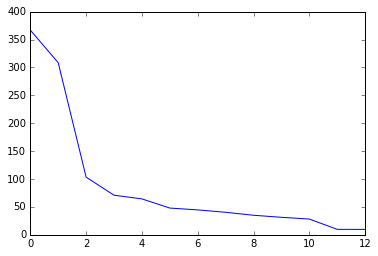

In [14]:
%matplotlib inline  
# We want to rank all attributes, and the best ones will be selected later
selector = SelectKBest(f_regression, k="all")
selector.fit(X_train, y_train)
sorted_attributes = np.argsort(-selector.scores_)
sorted_scores = np.sort(-selector.scores_)
for index,element in enumerate(zip(sorted_attributes, sorted_scores)):
    print element
    if index>10: break
        
plt.plot(-sorted_scores)
plt.show()

It seems that the first three attributes are the most correlated with the label. Let's see what happens if we select only the best three attributes.

In [15]:
# Select the first 3 best attributes
X_train_new = X_train[:, sorted_attributes[0:3]]
X_test_new = X_test[:, sorted_attributes[0:3]]

We can see that the error is not too different, even though we have removed most of the attributes.

In [16]:
clf = tree.DecisionTreeRegressor()
clf = clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print metrics.mean_squared_error(y_test, y_test_pred)

16.4673891626


Now, we are going to construct a method which is a combination or a sequence (a pipeline, in fact) of an attribute selector + a decision tree regressor. clf is therefore the pipeline (a sequence of attribute selection + regression algorithm). The number of attributes to be selected is a hyper-parameter of clf. max_depth is also a hyper-parameter of clf. We can use grid search in order to tune both parameters.

In [17]:
from sklearn.pipeline import Pipeline

param_grid = {'feature_selection__k': np.arange(X_train.shape[1])+1,
              'regression__max_depth': np.arange(4)+1}

clf = Pipeline([
  ('feature_selection', SelectKBest(f_regression)),
  ('regression', tree.DecisionTreeRegressor())
])

clf_grid = GridSearchCV(clf, 
                        param_grid,
                        scoring='mean_squared_error',
                        cv=5 , n_jobs=1, verbose=1)
%time _ = clf_grid.fit(X,y)

[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    0.6s


Fitting 5 folds for each of 52 candidates, totalling 260 fits
Wall time: 922 ms


[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    0.8s finished


Now, let's see the best hyper-parameters. It seems that for this case, 3 attributes should be selected

In [26]:
print clf_grid.best_params_, clf_grid.best_score_

{'feature_selection__k': 3, 'regression__max_depth': 3} -30.311835006


In [20]:
#

# USING PCA FOR TRANSFORMING ATTRIBUTES WITH TRAIN / TEST EVALUATION

In [21]:
from sklearn import decomposition
from sklearn import datasets

In [22]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
print X.shape
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=33)

(150L, 4L)


Let's use the maximum number of PCA components for the moment(4 iris attributes implies 4 attributes)

In [23]:
pca = decomposition.PCA(n_components=4)
pca.fit(X_train)


PCA(copy=True, n_components=4, whiten=False)

Now, let's see how much variance explains each of the four components. We can see that the first component explaines most of the variance 92%

In [24]:
pca.explained_variance_ratio_

array([ 0.92337895,  0.05717063,  0.01542177,  0.00402865])

Now, let's compute the cummulative variance explained by n components. It seems that with 2 components we can already explain more than 95% of the variance. Using that criterion, we should use 2 components.

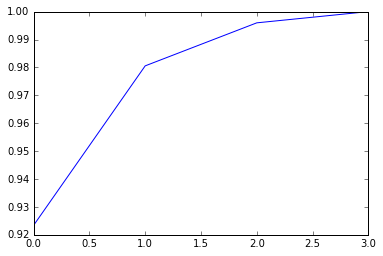

In [25]:
accumulated_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(accumulated_variance)
plt.show()


Therefore, let's compute 2 PCA components and apply them to train and test. We can see that the new input attributes (X_train_new and X_test_new have 2 new attributes) 

In [125]:
pca = decomposition.PCA(n_components=2)
pca.fit(X_train)
X_train_new = pca.transform(X_train)
X_test_new = pca.transform(X_test)

Now, we can apply a classifier to the new, reduced, training set, and test it on the transformed test set

In [130]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train_new, y_train)

In [136]:
y_train_pred = clf.predict(X_train_new)
y_test_pred = clf.predict(X_test_new)
print metrics.accuracy_score(y_train, y_train_pred)
print metrics.accuracy_score(y_test, y_test_pred)

1.0
0.916666666667


If we construct the tree with the original dataset (before applying PCA), we see that test accuracy is larger with 4 attributes than with 2 PCA components. So in this case, PCA would not be useful from an accuracy point of view, but it would be useful to reduce the complexity of the model (with PCA we have only 2 components instead of the 4 original attributes).

In [138]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
print metrics.accuracy_score(y_train, y_train_pred)
print metrics.accuracy_score(y_test, y_test_pred)

1.0
0.95
